In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import pandas as pd
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

In [ ]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true= tf.keras.layers.Flatten()(y_true)
    y_pred= tf.keras.layers.Flatten()(y_pred)
    intersection= tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth)/ (tf.reduce_sum(y_true) +tf.reduce_sum(y_pred) +smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
#UNET Implementation
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(inputs, num_filters):
    x= Conv2D(num_filters, 3,padding="same")(inputs)
    x= BatchNormalization()(x)
    x= Activation("relu")(x)

    x= Conv2D(num_filters, 3, padding="same")(x)
    x= BatchNormalization()(x)
    x= Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x= conv_block(inputs, num_filters)
    p= MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x= Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x= Concatenate()([x, skip_features])
    x= conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1,padding="same", activation="sigmoid")(d4)

    model =Model(inputs, outputs, name="UNET")
    return model

In [ ]:
if __name__ == "__main__":
    shape = (256, 256, 3)
    model = build_unet(shape)

    model.summary()

Model: "UNET"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

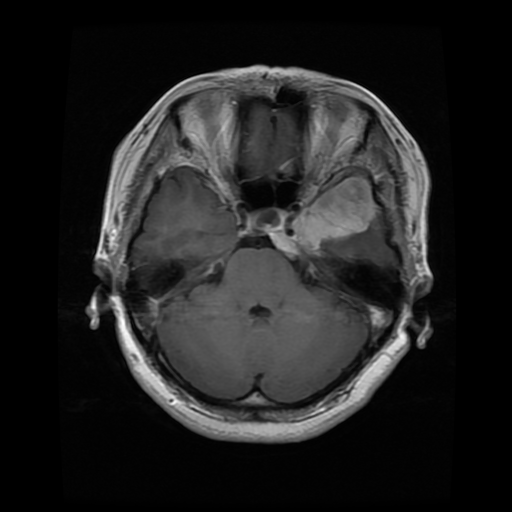

In [ ]:
from PIL import Image
from torchvision.transforms import ToTensor
image = Image.open("/content/drive/MyDrive/images/1.png")
mask= Image.open("/content/drive/MyDrive/masks/1.png")
image

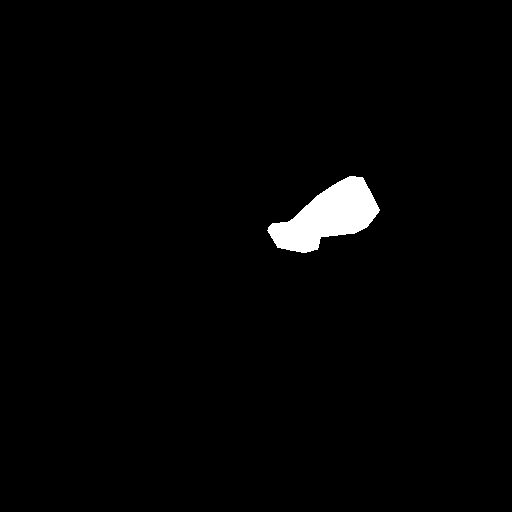

In [ ]:
mask

In [ ]:
#Training
""" Global parameters """
H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=43)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=43)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=43)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=43)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)


def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(43)
    tf.random.set_seed(43)

    create_dir("/content/drive/MyDrive/UNET_modelfiles")

    batch_size = 16
    lr= 1e-4
    num_epochs = 75

    model_path = os.path.join("/content/drive/MyDrive/UNET_modelfiles", "model.keras")
    csv_path = os.path.join("/content/drive/MyDrive/UNET_modelfiles", "log.csv")

    dataset_path = "/content/drive/MyDrive"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y)= load_dataset(dataset_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test : {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

    """ Model """
    model = build_unet((H, W, 3))
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef])

    callbacks= [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

    model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )

Train: 1840 - 1840
Valid: 612 - 612
Test : 612 - 612
Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - dice_coef: 0.0889 - loss: 0.9111 
Epoch 1: val_loss improved from inf to 0.95803, saving model to /content/drive/MyDrive/UNET_modelfiles/model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 1921s 16s/step - dice_coef: 0.0894 - loss: 0.9106 - val_dice_coef: 0.0417 - val_loss: 0.9580 - learning_rate: 1.0000e-04
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 787ms/step - dice_coef: 0.2401 - loss: 0.7599
Epoch 2: val_loss did not improve from 0.95803
115/115 ━━━━━━━━━━━━━━━━━━━━ 134s 894ms/step - dice_coef: 0.2403 - loss: 0.7597 - val_dice_coef: 0.0279 - val_loss: 0.9719 - learning_rate: 1.0000e-04
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - dice_coef: 0.3269 - loss: 0.6731
Epoch 3: val_loss did not improve from 0.95803
115/115 ━━━━━━━━━━━━━━━━━━━━ 111s 965ms/step - dice_coef: 0.3271 - loss: 0.6729 - val_dice_coef: 0.0249 - val_loss: 0.9750 - learning_rate: 1.0000e-04
Epoch 4/50
115/115 ━

In [ ]:
#Testing
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from tqdm import tqdm

""" Global parameters """
H = 256
W = 256

""" Creating a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def save_results(image, mask, y_pred, save_image_path):
    # ground truth mask to RGB for visualization
    mask = np.expand_dims(mask, axis=-1)
    mask_rgb = np.concatenate([mask, mask, mask], axis=-1)

    # prediction to RGB (for visualization purposes)
    y_pred_rgb = np.expand_dims(y_pred, axis=-1)
    y_pred_rgb = np.concatenate([y_pred_rgb, y_pred_rgb, y_pred_rgb], axis=-1) * 255

    # red overlay where the predicted mask is 1
    overlay = image.copy()
    red_color = (0, 0, 255)
    overlay[y_pred == 1] = red_color  # Apply red where prediction is 1
    blended = cv2.addWeighted(image, 0.7, overlay, 0.3, 0)  #0.7 original, 0.3 overlay
    line = np.ones((H, 10, 3)) * 255

    cat_images = np.concatenate([image, line, mask_rgb, line, y_pred_rgb, line,blended], axis=1)

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.6
    color = (255, 255, 255)
    thickness = 1

    cv2.putText(cat_images, "Original Image", (10, 30), font, font_scale, color, thickness, cv2.LINE_AA)
    cv2.putText(cat_images, "Ground Truth Mask", (H + 20, 30), font, font_scale, color, thickness, cv2.LINE_AA)
    cv2.putText(cat_images, "Predicted Mask", (2 * H + 30, 30), font, font_scale, color, thickness, cv2.LINE_AA)
    cv2.putText(cat_images, "Prediction Overlay", (3 * H + 30, 30), font, font_scale, color, thickness, cv2.LINE_AA)

    cv2.imwrite(save_image_path, cat_images)


if __name__ == "__main__":
    """ Seeding """
    np.random.seed(43)
    tf.random.set_seed(43)

    """ Directory for storing files """
    create_dir("/content/drive/MyDrive/UNET_res")

    """ Load the model """
    with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
        model = tf.keras.models.load_model(os.path.join("/content/drive/MyDrive/UNET_modelfiles", "model.keras"))

    """ Dataset """
    dataset_path = "/content/drive/MyDrive"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

    """ Prediction and Evaluation """
    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
        """ Extracting the name """
        name = x.split("/")[-1]

        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (W, H))
        x_input = image / 255.0
        x_input = np.expand_dims(x_input, axis=0)

        """ Reading the mask (ground truth) """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (W, H))

        """ Prediction """
        y_pred = model.predict(x_input, verbose=0)[0]
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = (y_pred >= 0.5).astype(np.int32)

        """ Saving the prediction with overlay """
        save_image_path = os.path.join("/content/drive/MyDrive/UNET_res", name)
        save_results(image, mask, y_pred, save_image_path)

        """ Flatten the arrays for metric calculations """
        mask_flat = (mask / 255.0).astype(np.int32).flatten()
        y_pred_flat = y_pred.flatten()

        """ Calculate the metrics values """
        f1_value = f1_score(mask_flat, y_pred_flat, labels=[0, 1], average="binary")
        jac_value = jaccard_score(mask_flat, y_pred_flat, labels=[0, 1], average="binary")
        recall_value = recall_score(mask_flat, y_pred_flat, labels=[0, 1], average="binary", zero_division=0)
        precision_value = precision_score(mask_flat, y_pred_flat, labels=[0, 1], average="binary", zero_division=0)

        SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

    """ Print metrics """
    score = np.mean([s[1:] for s in SCORE], axis=0)
    print(f"F1: {score[0]:0.5f}")
    print(f"Jaccard: {score[1]:0.5f}")
    print(f"Recall: {score[2]:0.5f}")
    print(f"Precision: {score[3]:0.5f}")

    """ Save scores to CSV """
    df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv("/content/drive/MyDrive/UNET_modelfiles/UNET_score.csv")


100%|██████████| 612/612 [10:23<00:00,  1.02s/it]

F1: 0.75158
Jaccard: 0.66984
Recall: 0.75861
Precision: 0.79713
